In [2]:
import requests
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as stat

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
# !pip install pmdarima
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer

from sklearn.pipeline import Pipeline

# Functions For Pre-processing Each Stock In Train Folder

In [13]:
import yfinance as yf

#  Paths (adjusted for folder structure)
stock_path = "data_yahoo/train/Stocks"     
indices_path = "data_yahoo/train/indices"  
test_stocks_path = "data_yahoo/test/stocks"       
test_indices_path = "data_yahoo/test/indices" 
def yahoo_to_kaggle_format(ticker, start="2015-01-01", end="2024-12-31", out_dir= stock_path):
    os.makedirs(out_dir, exist_ok=True)

    df = yf.download(
        ticker,
        start=start,
        end=end,
        auto_adjust=False,
        progress=False,
        group_by="ticker" 
    )

    if df.empty:
        print(f"[skip] No data for {ticker}")
        return None

    # Removes MultiIndex if present 
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = [c[1] if c[1] != '' else c[0] for c in df.columns]

    df = df.reset_index()

    # Standardize column names
    df = df.rename(columns={"Adj Close": "Adjusted"})

    # Add ticker column
    df["Ticker"] = ticker

    # Reorder to Kaggle schema
    df = df[["Date","Ticker","Open","High","Low","Close","Adjusted","Volume"]]

    out_path = os.path.join(out_dir, f"{ticker}.csv")
    df.to_csv(out_path, index=False)
    print(f"[ok] {ticker} -> {out_path} ({len(df)} rows)")
    return df

# Loop over 45 stocks
tickers = ['AAPL', 'ABBV', 'AXP', 'BA', 'BOOT', 'CALM', 'CAT', 'CL', 'CSCO', 'CVX', 'DD', 'DENN', 'DIS', 
 'F', 'GE', 'GM', 'GS', 'HON', 'IBM', 'INTC', 'IP', 'JNJ', 'JPM', 'KO', 'LMT', 'MA', 'MCD', 
 'MG', 'MMM', 'MS', 'MSFT', 'NKE', 'PEP', 'PFE', 'PG', 'RTX', 'SO', 'T', 'TDW', 'V', 'VZ', 'WFC', 'WMT', 'XELB', 'XOM'
]
indices = ['^GSPC','^DJI','^IXIC']

# Files already saved so code commented out


# # Training data for stock data from start of 2015 to end of 2024
# for ticker in tickers:
#     ticker = yahoo_to_kaggle_format(ticker)


# # Training data for indices data from start of 2015 to end of 2024
# for ticker in indices:
#     ticker = yahoo_to_kaggle_format(ticker, out_dir= indices_path)

# Test sets for stock data for 2025
# for ticker in tickers:
#     ticker = yahoo_to_kaggle_format(ticker, start="2025-01-01", end="2025-09-01", out_dir= test_stocks_path)
    
# Test data for indices data for 2015
for ticker in indices:
    ticker = yahoo_to_kaggle_format(ticker, start="2025-01-01", end="2025-09-01",  out_dir= test_indices_path)

apple = yahoo_to_kaggle_format("AAPL", start="2015-01-01")
print(apple.head())
apple.info()

[ok] ^GSPC -> data_yahoo/test/indices/^GSPC.csv (165 rows)
[ok] ^DJI -> data_yahoo/test/indices/^DJI.csv (165 rows)
[ok] ^IXIC -> data_yahoo/test/indices/^IXIC.csv (165 rows)
[ok] AAPL -> data_yahoo/train/Stocks/AAPL.csv (2515 rows)
        Date Ticker       Open       High        Low      Close   Adjusted  \
0 2015-01-02   AAPL  27.847500  27.860001  26.837500  27.332500  24.261044   
1 2015-01-05   AAPL  27.072500  27.162500  26.352501  26.562500  23.577581   
2 2015-01-06   AAPL  26.635000  26.857500  26.157499  26.565001  23.579790   
3 2015-01-07   AAPL  26.799999  27.049999  26.674999  26.937500  23.910437   
4 2015-01-08   AAPL  27.307501  28.037500  27.174999  27.972500  24.829128   

      Volume  
0  212818400  
1  257142000  
2  263188400  
3  160423600  
4  237458000  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2515 entries, 0 to 2514
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date 

In [19]:
def preprocess_stock(file_path):
    """
    Load a stock or index CSV, parse dates, sort, drop bad rows,
    and compute log adjusted returns.
    """
    df = pd.read_csv(file_path)

    # Parse date column
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df = df.dropna(subset=['Date'])  # drop invalid dates
    df = df.sort_values('Date').drop_duplicates(subset=['Date'], keep='last')

    # Ensure Adjusted price exists
    if 'Adjusted' not in df.columns:
        raise ValueError(f"'Adjusted' column missing in {file_path}")

    # Compute log adjusted returns
    df['Log_Adj_Return'] = np.log(df['Adjusted'] / df['Adjusted'].shift(1))
    df = df.dropna(subset=['Log_Adj_Return'])

    df.set_index('Date', inplace=True)
    return df

In [21]:
# Load all stocks into dictionary 
stocks_dict = {}
for file in os.listdir(stock_path):
    if file.endswith(".csv"):
        ticker = file.replace(".csv", "")
        stocks_dict[ticker] = preprocess_stock(os.path.join(stock_path, file))


In [23]:
stocks_dict
print("Number of stocks loaded:", len(stocks_dict))
print("Stock tickers:", list(stocks_dict.keys())[:10], "...")
for ticker in list(stocks_dict.keys())[:3]:  # first 3 stocks
    print(f"\nTicker: {ticker}")
    
    print(stocks_dict[ticker].info())
    print(stocks_dict[ticker].head())
    print(stocks_dict[ticker].tail())

Number of stocks loaded: 45
Stock tickers: ['CSCO', 'BA', 'TDW', 'BOOT', 'V', 'T', 'XELB', 'F', 'PEP', 'ABBV'] ...

Ticker: CSCO
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2514 entries, 2015-01-05 to 2024-12-30
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Ticker          2514 non-null   object 
 1   Open            2514 non-null   float64
 2   High            2514 non-null   float64
 3   Low             2514 non-null   float64
 4   Close           2514 non-null   float64
 5   Adjusted        2514 non-null   float64
 6   Volume          2514 non-null   int64  
 7   Log_Adj_Return  2514 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 176.8+ KB
None
           Ticker       Open       High        Low      Close   Adjusted  \
Date                                                                       
2015-01-05   CSCO  27.320000  27.450001  27.000000  27.059999  19.538145   


In [25]:
for ticker in ['AAPL', 'MSFT']:  # pick some known names
    print(f"\n{ticker} returns summary:")
    print(stocks_dict[ticker]['Log_Adj_Return'].describe())
    print(stocks_dict[ticker].shape)


AAPL returns summary:
count    2514.000000
mean        0.000930
std         0.017934
min        -0.137708
25%        -0.007356
50%         0.001000
75%         0.010093
max         0.113157
Name: Log_Adj_Return, dtype: float64
(2514, 8)

MSFT returns summary:
count    2514.000000
mean        0.000938
std         0.017093
min        -0.159453
25%        -0.006750
50%         0.000958
75%         0.009732
max         0.132929
Name: Log_Adj_Return, dtype: float64
(2514, 8)


In [27]:
# Load indices into dictionary 
indices_dict = {}
for file in os.listdir(indices_path):
    if file.endswith(".csv"):
        idx_name = file.replace(".csv", "")
        indices_dict[idx_name] = preprocess_stock(os.path.join(indices_path, file))

# Train indices
if os.path.exists("data_yahoo/train/indices/^GSPC.csv"):
    os.rename("data_yahoo/train/indices/^GSPC.csv", "data_yahoo/train/indices/SP500.csv")
if os.path.exists("data_yahoo/train/indices/^DJI.csv"):
    os.rename("data_yahoo/train/indices/^DJI.csv", "data_yahoo/train/indices/Dow_Jones.csv")
if os.path.exists("data_yahoo/train/indices/^IXIC.csv"):
    os.rename("data_yahoo/train/indices/^IXIC.csv", "data_yahoo/train/indices/NASDAQ.csv")

# Test indices
if os.path.exists("data_yahoo/test/indices/^GSPC.csv"):
    os.rename("data_yahoo/test/indices/^GSPC.csv", "data_yahoo/test/indices/SP500.csv")
if os.path.exists("data_yahoo/test/indices/^DJI.csv"):
    os.rename("data_yahoo/test/indices/^DJI.csv", "data_yahoo/test/indices/Dow_Jones.csv")
if os.path.exists("data_yahoo/test/indices/^IXIC.csv"):
    os.rename("data_yahoo/test/indices/^IXIC.csv", "data_yahoo/test/indices/NASDAQ.csv")

indices_dict["SP500"]["Ticker"] = "SP500"
indices_dict["Dow_Jones"]["Ticker"] = "Dow_Jones"
indices_dict["NASDAQ"]["Ticker"] = "NASDAQ"

In [29]:
indices_dict
print("Number of indices loaded:", len(indices_dict))
print("Indices tickers:", list(indices_dict.keys())[:10], "...")
for ticker in list(indices_dict.keys())[:3]:  # first 3 stocks
    print(f"\nTicker: {ticker}")
    print(indices_dict[ticker].info())
    # print(indices_dict[ticker].head())
    # print(indices_dict[ticker].tail())

Number of indices loaded: 3
Indices tickers: ['Dow_Jones', 'NASDAQ', 'SP500'] ...

Ticker: Dow_Jones
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2514 entries, 2015-01-05 to 2024-12-30
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Ticker          2514 non-null   object 
 1   Open            2514 non-null   float64
 2   High            2514 non-null   float64
 3   Low             2514 non-null   float64
 4   Close           2514 non-null   float64
 5   Adjusted        2514 non-null   float64
 6   Volume          2514 non-null   int64  
 7   Log_Adj_Return  2514 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 176.8+ KB
None

Ticker: NASDAQ
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2514 entries, 2015-01-05 to 2024-12-30
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Ticker          2514 

# Correlation of each stock with the 3 indices and stock to stock comparions

In [33]:
# Build DataFrame of all returns
all_returns = pd.DataFrame()

# Add all stocks
for ticker, df in stocks_dict.items():
    all_returns[ticker] = df['Log_Adj_Return']

# Add indices
for idx_name, df in indices_dict.items():
    all_returns[idx_name] = df['Log_Adj_Return']

# Drop rows with NaNs (keep only aligned trading days)
all_returns = all_returns.dropna(how='any')

# --- Compute correlation matrix ---
corr_matrix = all_returns.corr()

# Stocks
stock_names   = list(stocks_dict.keys()) 

# Indices
indices_names = list(indices_dict.keys())  # ['Dow_Jones', 'NASDAQ', 'SP500']

# Exclude index–index rows
stock_vs_stock = corr_matrix.loc[stock_names, stock_names]
stock_vs_indices = corr_matrix.loc[stocks_dict.keys(), indices_names]

print("\nStock vs Indices correlations:")
print(stock_vs_indices)

print("\nStock vs Stock correlations:")
print(stock_vs_stock)




Stock vs Indices correlations:
      Dow_Jones    NASDAQ     SP500
CSCO   0.694059  0.644381  0.696495
BA     0.678135  0.532306  0.607079
TDW    0.296063  0.199001  0.271859
BOOT   0.435945  0.401046  0.434750
V      0.770811  0.708224  0.769784
T      0.535768  0.353323  0.487927
XELB   0.170858  0.156962  0.169406
F      0.590241  0.503052  0.579895
PEP    0.623165  0.484479  0.601756
ABBV   0.465481  0.381715  0.454840
PG     0.558045  0.411013  0.532263
DENN   0.490937  0.399783  0.454885
CAT    0.692192  0.531458  0.635475
MCD    0.658460  0.501755  0.605506
INTC   0.583212  0.635546  0.624904
GM     0.631458  0.533970  0.607877
MMM    0.656669  0.494386  0.597765
IP     0.629191  0.483094  0.598130
KO     0.634623  0.438711  0.591643
MSFT   0.712220  0.845368  0.799615
DD     0.675743  0.550257  0.651190
CALM   0.251150  0.191328  0.235101
RTX    0.704936  0.501563  0.633418
AXP    0.752232  0.587314  0.700218
SO     0.497171  0.322476  0.470430
XOM    0.614041  0.401877  0.552

In [35]:
tickers = list(stocks_dict.keys())[:10]  # try first 10

for t in tickers:
    info = yf.Ticker(t).info
    print(f"{t}: {info.get('longName')}")

CSCO: Cisco Systems, Inc.
BA: The Boeing Company
TDW: Tidewater Inc.
BOOT: Boot Barn Holdings, Inc.
V: Visa Inc.
T: AT&T Inc.
XELB: Xcel Brands, Inc.
F: Ford Motor Company
PEP: PepsiCo, Inc.
ABBV: AbbVie Inc.


In [37]:
print(sorted(stocks_dict.keys()))

['AAPL', 'ABBV', 'AXP', 'BA', 'BOOT', 'CALM', 'CAT', 'CL', 'CSCO', 'CVX', 'DD', 'DENN', 'DIS', 'F', 'GE', 'GM', 'GS', 'HON', 'IBM', 'INTC', 'IP', 'JNJ', 'JPM', 'KO', 'LMT', 'MA', 'MCD', 'MG', 'MMM', 'MS', 'MSFT', 'NKE', 'PEP', 'PFE', 'PG', 'RTX', 'SO', 'T', 'TDW', 'V', 'VZ', 'WFC', 'WMT', 'XELB', 'XOM']


In [39]:
ticker_names = {
    "AAPL": "Apple Inc.",
    "ABBV": "AbbVie Inc.",
    "AXP": "American Express Company",
    "BA": "Boeing Company",
    "BOOT": "Boot Barn Holdings Inc.",
    "CALM": "Cal-Maine Foods Inc.",
    "CAT": "Caterpillar Inc.",
    "CL": "Colgate-Palmolive Company",
    "CSCO": "Cisco Systems Inc.",
    "CVX": "Chevron Corporation",
    "DD": "DuPont de Nemours Inc.",
    "DENN": "Denny’s Corporation",
    "DIS": "Walt Disney Company",
    "F": "Ford Motor Company",
    "GE": "General Electric Company",
    "GM": "General Motors Company",
    "GS": "Goldman Sachs Group Inc.",
    "HON": "Honeywell International Inc.",
    "IBM": "International Business Machines Corp.",
    "INTC": "Intel Corporation",
    "IP": "International Paper Company",
    "JNJ": "Johnson & Johnson",
    "JPM": "JPMorgan Chase & Co.",
    "KO": "Coca-Cola Company",
    "LMT": "Lockheed Martin Corporation",
    "MA": "Mastercard Inc.",
    "MCD": "McDonald’s Corporation",
    "MG": "Mistras Group Inc.", 
    "MMM": "3M Company",
    "MS": "Morgan Stanley",
    "MSFT": "Microsoft Corporation",
    "NKE": "Nike Inc.",
    "PEP": "PepsiCo Inc.",
    "PFE": "Pfizer Inc.",
    "PG": "Procter & Gamble Company",
    "RTX": "RTX Corporation",
    "SO": "Southern Company",
    "T": "AT&T Inc.",
    "TDW": "Tidewater Inc.",
    "V": "Visa Inc.",
    "VZ": "Verizon Communications Inc.",
    "WFC": "Wells Fargo & Co.",
    "WMT": "Walmart Inc.",
    "XELB": "Xcel Brands Inc.",
    "XOM": "Exxon Mobil Corporation"
}



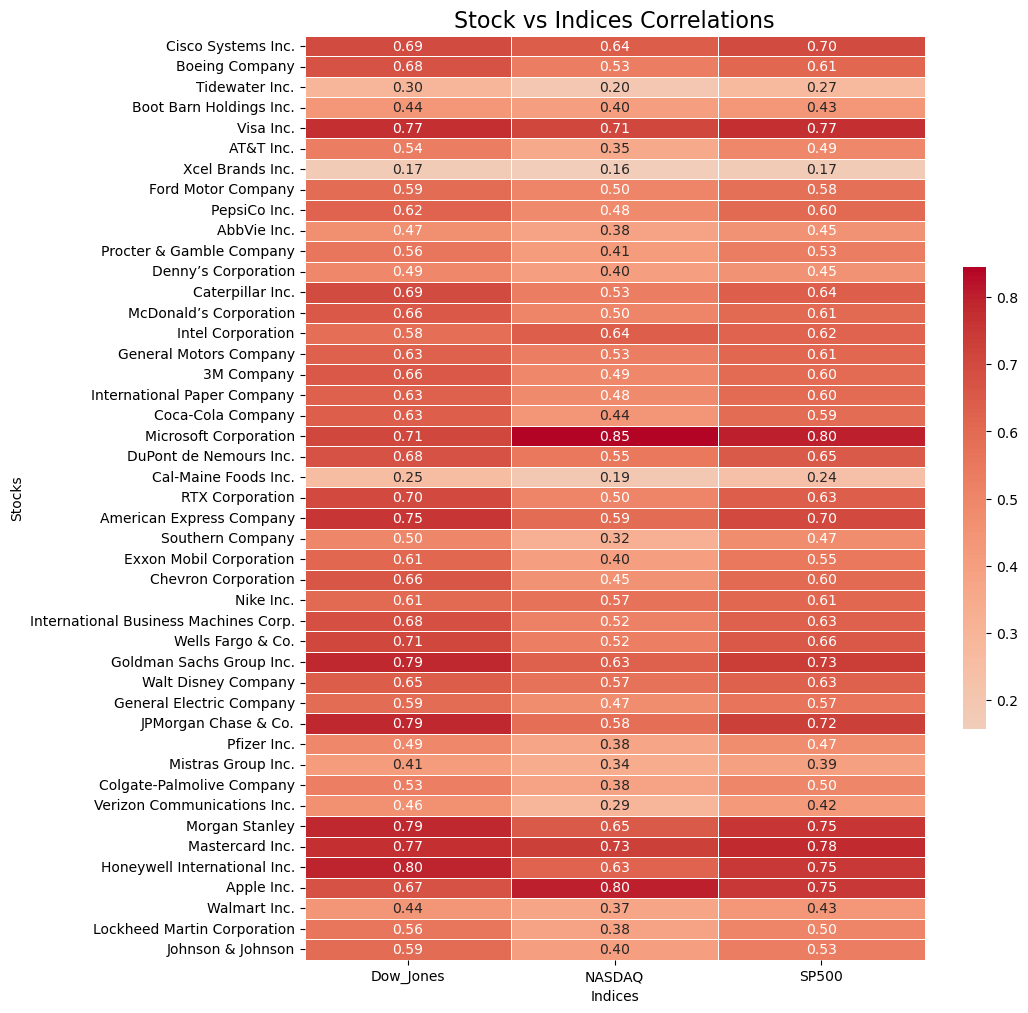

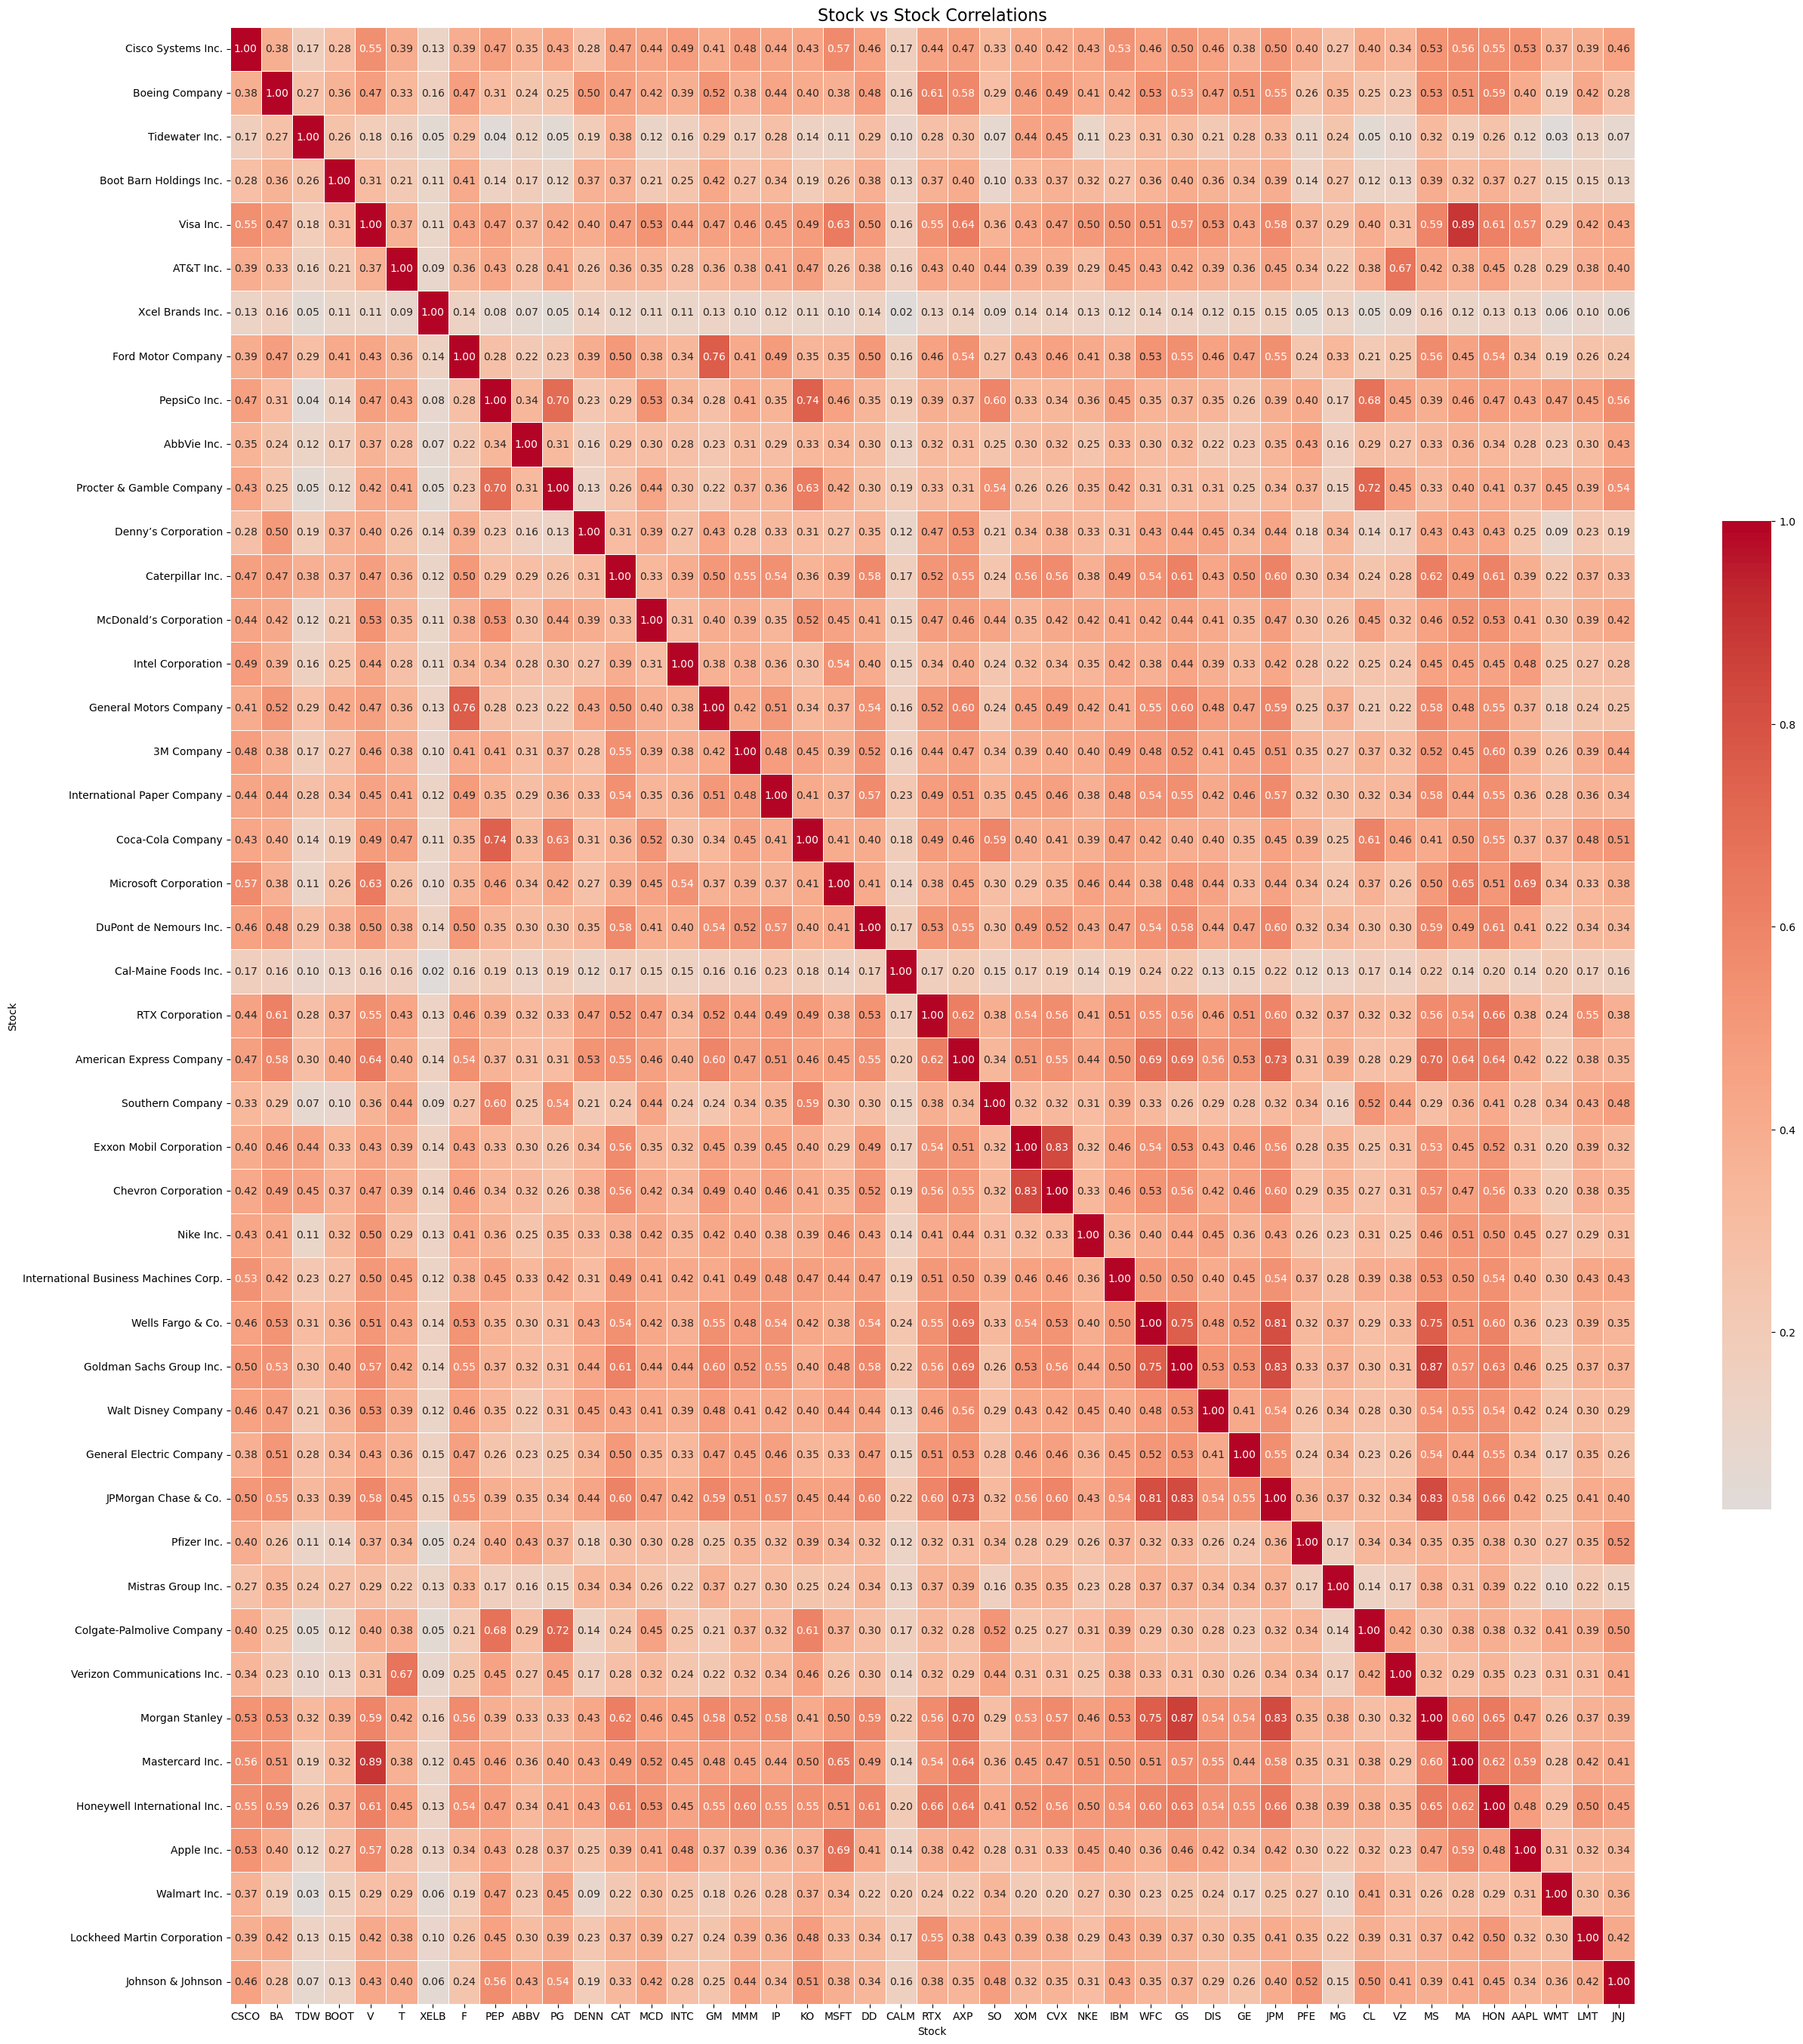

In [41]:
# Rename correlation matrix
stock_vs_indices_named = stock_vs_indices.rename(index=ticker_names)
stock_vs_stock_named = stock_vs_stock.rename(index=ticker_names)
# Heatmap only for stock-index correlations
plt.figure(figsize=(10, 12))
sns.heatmap(stock_vs_indices_named, cmap="coolwarm", center=0, 
            linewidths=.5, annot=True, fmt=".2f", cbar_kws={"shrink": .5})
plt.title("Stock vs Indices Correlations", fontsize=16)
plt.ylabel("Stocks")
plt.xlabel("Indices")
plt.show()

# Heatmap only for stock-stock correlations
plt.figure(figsize=(30, 34))
sns.heatmap(stock_vs_stock_named, cmap="coolwarm", center=0, 
            linewidths=.5, annot=True, fmt=".2f", cbar_kws={"shrink": .5})
plt.title("Stock vs Stock Correlations", fontsize=16)
plt.ylabel("Stock")
plt.xlabel("Stock")
plt.show()



## ARIMAX Time Series Model

In [49]:
r_squared_arimax = {}
trained_models = {}
results = {}
mae_results = {}
best_orders = {}      # ticker -> (p,d,q)
for ticker, df_stock in stocks_dict.items():
    # 1) stock daily returns and 5-day forward sum as target
    y = df_stock['Log_Adj_Return'].dropna().sort_index()
    y_fwd5 = y.shift(-1).rolling(5, min_periods=5).sum().rename('y_fwd5')  # target
    y_fwd5 = y_fwd5.dropna()

    # 2) exogenous: use lag-1 index returns to avoid look-ahead (match RF)
    exog = pd.concat([
        indices_dict['NASDAQ']['Log_Adj_Return'].shift(1).rename('NASDAQ_lag1'),
        indices_dict['SP500']['Log_Adj_Return'].shift(1).rename('SP500_lag1'),
        indices_dict['Dow_Jones']['Log_Adj_Return'].shift(1).rename('Dow_lag1'),
    ], axis=1)

    # 3) align target with exog, keep common dates
    combined = pd.concat([y_fwd5, exog], axis=1, join='inner').dropna().sort_index()
    if len(combined) < 200:
        continue  # skip very short series to keep ARIMA stable

    # 4) split: first 80% train, last 20% test of dates per ticker
    n = len(combined)
    cut = int(n * 0.80)
    train, test = combined.iloc[:cut], combined.iloc[cut:]
    test_dates = pd.to_datetime(test.index).tz_localize(None)

    # 5) numeric + RangeIndex for SARIMAX
    y_tr = train['y_fwd5'].astype(float).reset_index(drop=True)
    X_tr = train[['NASDAQ_lag1','SP500_lag1','Dow_lag1']].astype(float).reset_index(drop=True)
    y_te = test['y_fwd5'].astype(float).reset_index(drop=True)
    X_te = test[['NASDAQ_lag1','SP500_lag1','Dow_lag1']].astype(float).reset_index(drop=True)

    model_autoARIMA = auto_arima(y_tr, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      stepwise=True)
    print(
    f"{ticker}: order={model_autoARIMA.order}, d={model_autoARIMA.order[1]}, "
    f"AIC={model_autoARIMA.aic():.2f}, BIC={model_autoARIMA.bic():.2f}"
    )
    best_orders[ticker] = model_autoARIMA.order  
    # best_orders[ticker] = tuple(model_autoARIMA.order)
    # print("Best ARIMA order:", model_autoARIMA.order)

    if ticker not in best_orders: 
        continue
    order = best_orders[ticker]
    
    # 6) ARIMAX:
    model = SARIMAX(
        y_tr, exog=X_tr, order=order,
        enforce_stationarity=False, enforce_invertibility=False
    )
    fit = model.fit(method='powell', maxiter=800, disp=False)
    if not fit.mle_retvals.get("converged", True):
        fit = model.fit(method='nm', maxiter=1200, disp=False)

    trained_models[ticker] = fit   # save the trained model for later use

    # 7) forecast y_fwd5 on the validation block with exog
    fc = fit.get_forecast(steps=len(y_te), exog=X_te)
    pred = fc.predicted_mean
    pred.index = test_dates

    rmse = np.sqrt(mean_squared_error(test['y_fwd5'], pred))
    results[ticker] = {"rmse": rmse}
    mae = mean_absolute_error(test['y_fwd5'], pred)
    mae_results[ticker] = {"mae": mae}
    rsq_arimax = r2_score(test['y_fwd5'], pred)
    r_squared_arimax[ticker] = {"rsq_arimax": rsq_arimax }

    
    
    rmse = np.sqrt(mean_squared_error(test['y_fwd5'], pred))
    mae = mean_absolute_error(test['y_fwd5'], pred)
    rsq_arimax = r2_score(test['y_fwd5'], pred)
    print(f"{ticker}: ARIMAX(y_fwd5 | lagged indices) RMSE={rmse:.4f}")
    print(f"{ticker}: ARIMAX(y_fwd5 | lagged indices) MAE={mae:.4f}")
    print(f"{ticker}: ARIMAX(y_fwd5 | lagged indices) R_squared={rsq_arimax:.4f}")
    
     # rmse = np.sqrt(mean_squared_error(test['y_fwd5'], pred))


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-7891.662, Time=0.20 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-9644.059, Time=0.21 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-8978.113, Time=0.33 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-9644.632, Time=0.58 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-9647.493, Time=0.58 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-9641.245, Time=0.67 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-9640.673, Time=0.46 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-9646.631, Time=4.04 sec

Best model:  ARIMA(3,0,0)(0,0,0)[0]          
Total fit time: 7.094 seconds
CSCO: order=(3, 0, 0), d=0, AIC=-9647.49, BIC=-9625.08
CSCO: ARIMAX(y_fwd5 | lagged indices) RMSE=0.0281
CSCO: ARIMAX(y_fwd5 | lagged indices) MAE=0.0212
CSCO: ARIMAX(y_fwd5 | lagged indices) MAE=-0.0162
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-5238.745, Time=0.17 sec
 ARIMA(1,0,0)(0,0,0)[0]       

In [97]:
# average RMSE, MAE, R^2 across all stocks
if results:
    avg_rmse = np.mean([v["rmse"] for v in results.values()])
    print(f"\nAverage ARIMAX RMSE across {len(results)} stocks: {avg_rmse:.3f}")

if mae_results:
    avg_mae = np.mean([v["mae"] for v in mae_results.values()])
    print(f"\nAverage ARIMAX MAE across {len(mae_results)} stocks: {avg_mae:.3f}")

if r_squared_arimax:
    avg_r2 = np.mean([v["rsq_arimax"] for v in r_squared_arimax.values()])
    print(f"\nAverage ARIMAX R squared across {len(r_squared_arimax)} stocks: {avg_r2:.3f}")


Average ARIMAX RMSE across 45 stocks: 0.037

Average ARIMAX MAE across 45 stocks: 0.028

Average ARIMAX R squared across 45 stocks: -0.007


In [99]:
# Load all test into dictionary for test arima
test_dict_arimax = {}
for file in os.listdir(test_stocks_path):
    if file.endswith(".csv"):
        ticker = file.replace(".csv", "")
        test_dict_arimax[ticker] = preprocess_stock(os.path.join(test_stocks_path, file))

indices_dict_arimax = {}
for file in os.listdir(test_indices_path):
    if file.endswith(".csv"):
        idx_name = file.replace(".csv", "")
        indices_dict_arimax[idx_name] = preprocess_stock(os.path.join(test_indices_path, file))
best_orders
# test_dict_arimax.items()

{'CSCO': (3, 0, 0),
 'BA': (3, 0, 3),
 'TDW': (3, 0, 3),
 'BOOT': (2, 0, 2),
 'V': (3, 0, 1),
 'T': (1, 0, 3),
 'XELB': (3, 0, 3),
 'F': (2, 0, 2),
 'PEP': (3, 0, 0),
 'ABBV': (2, 0, 3),
 'PG': (1, 0, 3),
 'DENN': (2, 0, 2),
 'CAT': (3, 0, 3),
 'MCD': (3, 0, 1),
 'INTC': (3, 0, 3),
 'GM': (2, 0, 2),
 'MMM': (3, 0, 3),
 'IP': (3, 0, 0),
 'KO': (3, 0, 0),
 'MSFT': (1, 0, 0),
 'DD': (2, 0, 2),
 'CALM': (1, 0, 3),
 'RTX': (3, 0, 3),
 'AXP': (2, 0, 2),
 'SO': (3, 0, 1),
 'XOM': (3, 0, 0),
 'CVX': (3, 0, 0),
 'NKE': (1, 0, 3),
 'IBM': (3, 0, 0),
 'WFC': (3, 0, 0),
 'GS': (3, 0, 0),
 'DIS': (3, 0, 3),
 'GE': (3, 0, 3),
 'JPM': (1, 0, 3),
 'PFE': (2, 0, 3),
 'MG': (2, 0, 1),
 'CL': (2, 0, 3),
 'VZ': (3, 0, 0),
 'MS': (3, 0, 0),
 'MA': (2, 0, 2),
 'HON': (2, 0, 1),
 'AAPL': (3, 0, 3),
 'WMT': (1, 0, 3),
 'LMT': (2, 0, 3),
 'JNJ': (2, 0, 3)}

In [101]:
#Test ARIMAX on 2025 test data

r_squared_arimax_2025 = {}
mae_results_2025 = {}
results_2025 = {}
      # ticker -> (p,d,q)
for ticker, df_stock in test_dict_arimax.items():
    # 1) stock daily returns and 5-day forward sum as target
    y = df_stock['Log_Adj_Return'].dropna().sort_index()
    y_fwd5 = y.shift(-1).rolling(5, min_periods=5).sum().rename('y_fwd5')  # target
    y_fwd5 = y_fwd5.dropna()

    # 2) exogenous: use lag-1 index returns to avoid look-ahead (match RF)
    exog = pd.concat([
        indices_dict_arimax['NASDAQ']['Log_Adj_Return'].shift(1).rename('NASDAQ_lag1'),
        indices_dict_arimax['SP500']['Log_Adj_Return'].shift(1).rename('SP500_lag1'),
        indices_dict_arimax['Dow_Jones']['Log_Adj_Return'].shift(1).rename('Dow_lag1'),
    ], axis=1)

    # 3) align target with exog, keep common dates
    combined = pd.concat([y_fwd5, exog], axis=1, join='inner').dropna().sort_index()
    
   
    # 5) numeric + RangeIndex for SARIMAX
    y_te = combined['y_fwd5'].astype(float).reset_index(drop=True)
    X_te = combined[['NASDAQ_lag1','SP500_lag1','Dow_lag1']].astype(float).reset_index(drop=True)
    
    
    
     # pull the *trained* model from 2015–2024
    fit = trained_models[ticker]

    # 7) forecast y_fwd5 on the test block with exog
    fc_2025 = fit.get_forecast(steps=len(X_te), exog=X_te)
    pred_2025 = fc_2025.predicted_mean
    pred_2025.index = X_te.index

    rmse = np.sqrt(mean_squared_error(y_te, pred_2025))
    results_2025[ticker] = {"rmse": rmse}
    mae = mean_absolute_error(y_te, pred_2025)
    mae_results_2025[ticker] = {"mae": mae}
    r_squared = r2_score(y_te, pred_2025)
    r_squared_arimax_2025[ticker] = {"r_squared": r_squared}
    
    print(f"{ticker}: ARIMAX(y_fwd5 | lagged indices) RMSE={rmse:.4f}")
    print(f"{ticker}: ARIMAX(y_fwd5 | lagged indices) MAE={mae:.4f}")
    print(f"{ticker}: ARIMAX(y_fwd5 | lagged indices) R2={r_squared:.4f}")

# average RMSE, MAE, R squared across stocks for a single headline number
if results_2025:
    avg_rmse_test = np.mean([v["rmse"] for v in results_2025.values()])
    print(f"\nAverage ARIMAX RMSE across {len(results_2025)} stocks: {avg_rmse_test:.3f}")

if mae_results_2025:
    avg_mae_test = np.mean([v["mae"] for v in mae_results_2025.values()])
    print(f"\nAverage ARIMAX MAE across {len(mae_results_2025)} stocks: {avg_mae_test:.3f}")

if r_squared_arimax_2025:
    avg_rtest = np.mean([v["r_squared"] for v in r_squared_arimax_2025.values()])
    print(f"\nAverage ARIMAX R squared across {len(r_squared_arimax_2025)} stocks: {avg_rtest:.4f}")




CSCO: ARIMAX(y_fwd5 | lagged indices) RMSE=0.0351
CSCO: ARIMAX(y_fwd5 | lagged indices) MAE=0.0264
CSCO: ARIMAX(y_fwd5 | lagged indices) R2=-0.0590
BA: ARIMAX(y_fwd5 | lagged indices) RMSE=0.0616
BA: ARIMAX(y_fwd5 | lagged indices) MAE=0.0461
BA: ARIMAX(y_fwd5 | lagged indices) R2=-0.0218
TDW: ARIMAX(y_fwd5 | lagged indices) RMSE=0.0799
TDW: ARIMAX(y_fwd5 | lagged indices) MAE=0.0623
TDW: ARIMAX(y_fwd5 | lagged indices) R2=-0.0135
BOOT: ARIMAX(y_fwd5 | lagged indices) RMSE=0.0822
BOOT: ARIMAX(y_fwd5 | lagged indices) MAE=0.0612
BOOT: ARIMAX(y_fwd5 | lagged indices) R2=-0.0072
V: ARIMAX(y_fwd5 | lagged indices) RMSE=0.0328
V: ARIMAX(y_fwd5 | lagged indices) MAE=0.0259
V: ARIMAX(y_fwd5 | lagged indices) R2=0.0199
T: ARIMAX(y_fwd5 | lagged indices) RMSE=0.0296
T: ARIMAX(y_fwd5 | lagged indices) MAE=0.0240
T: ARIMAX(y_fwd5 | lagged indices) R2=-0.0964
XELB: ARIMAX(y_fwd5 | lagged indices) RMSE=0.1341
XELB: ARIMAX(y_fwd5 | lagged indices) MAE=0.1006
XELB: ARIMAX(y_fwd5 | lagged indices) R2=

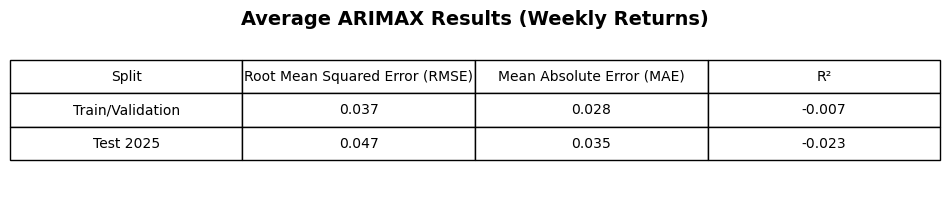

In [150]:
arimax_summary = {
    "Split": ["Train/Validation", "Test 2025"],
    "Root Mean Squared Error (RMSE)": [avg_rmse, avg_rmse_test],
    "Mean Absolute Error (MAE)": [avg_mae, avg_mae_test],
    "R²": [avg_r2, avg_rtest]
}

# Convert to DataFrame
df_summary = pd.DataFrame(arimax_summary)

# Plot as table
fig, ax = plt.subplots(figsize=(6, 2))
ax.axis('off')

table = ax.table(
    cellText=df_summary.round(3).values,   # <-- array of cell values
    colLabels=df_summary.columns.tolist(), # <-- list of column names
    loc='center',
    cellLoc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(2, 2)

plt.title("Average ARIMAX Results (Weekly Returns)", fontsize=14, weight='bold')
plt.savefig("arimax_metrics_table.png", dpi=300, bbox_inches="tight")
plt.show()

In [51]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split



IDX_NAMES = ['NASDAQ', 'SP500', 'Dow_Jones']


def build_features_for_stock(df_stock, indices_dict, window=20):
  
    
    # Target = stock log returns
    y = df_stock['Log_Adj_Return'].dropna().rename('y')
    y.index = pd.to_datetime(y.index)
    y = y.sort_index()
    

    """
    For ONE stock:
      - create past-only stock features and y_next
      - return a dataset with no NaN
    """
    
    # Align stock with indices

    parts = [y]
    for nm in IDX_NAMES:
        s = indices_dict[nm]['Log_Adj_Return'].rename(nm).dropna()
        s.index = pd.to_datetime(s.index)
        parts.append(s.sort_index())

    aligned = pd.concat([y] + [indices_dict[nm]['Log_Adj_Return'].rename(nm) for nm in IDX_NAMES],axis=1, join='inner').sort_index()
    
 
    # Start feature frame with stock and chosen index
    df = aligned[['y', 'NASDAQ', 'SP500', 'Dow_Jones']].copy()

    # Lags of stock and indices
    df['Lag1'] = df['y'].shift(1)
    df['Lag2'] = df['y'].shift(2)
    df['Lag5'] = df['y'].shift(5)
    
    df['NASDAQ_lag1'] = df['NASDAQ'].shift(1)
    df['SP500_lag1'] = df['SP500'].shift(1)
    df['Dow_Jones_lag1'] = df['Dow_Jones'].shift(1)
    

   
    # Rolling/EMA features
    df['Vol20']   = df['y'].rolling(window).std()
    df['EMA20']   = df['y'].ewm(span=window, adjust=False).mean()
    df['SMA5']    = df['y'].rolling(5).mean()
    df['SMA20']   = df['y'].rolling(window).mean()
    df['BollPct'] = (df['y'] - df['SMA20']) / (2 * df['y'].rolling(window).std())

    # Momentum = rolling sum of returns
    df['Mom5']  = df['y'].rolling(5,  min_periods=5).sum()
    df['Mom10'] = df['y'].rolling(10, min_periods=10).sum()

    # RSI (relative strength index, 14-day)
    gains  = df['y'].diff().clip(lower=0)
    losses = -df['y'].diff().clip(upper=0)

    avg_gain = gains.rolling(14, min_periods=14).mean()
    avg_loss = losses.rolling(14, min_periods=14).mean()

    rs = avg_gain / avg_loss.replace(0, np.nan)
    df['RSI14'] = 100 - (100 / (1 + rs))
    
    df['NASDAQ_Vol20'] = df['NASDAQ'].rolling(window).std()
    df['SP500_Vol20'] = df['SP500'].rolling(window).std()
    df['Dow_Jones_Vol20'] = df['Dow_Jones'].rolling(window).std()

    df['NASDAQ_EMA20'] = df['NASDAQ'].ewm(span=window, adjust=False).mean()
    df['SP500_EMA20'] = df['SP500'].ewm(span=window, adjust=False).mean()
    df['Dow_Jones_EMA20'] = df['Dow_Jones'].ewm(span=window, adjust=False).mean()
    
    # Next-day target
    df['y_next'] = df['y'].shift(-1)

    df['y_fwd5'] = df['y_next'].rolling(5, min_periods=5).sum()
    df['y_up'] = (df['y_fwd5'] > 0).astype(int)


    df = df.replace([np.inf, -np.inf], np.nan).dropna()

    return df

print("indices_dict keys:", list(indices_dict.keys()))
# Make sure you see exactly: ['NASDAQ', 'SP500', 'Dow_Jones']

indices_dict keys: ['Dow_Jones', 'NASDAQ', 'SP500']


In [148]:
# combined.info()




# Machine Learning Modelling 

In [53]:

def stack_all_stocks(stocks_dict, indices_dict):
    """
    Build features for each stock and stack into one DataFrame.

    - stocks_dict: {ticker: df_stock} with df_stock indexed by Date and a 'Log_Adj_Return' column
    - indices_dict: {'NASDAQ': df, 'SP500': df, 'Dow_Jones': df} each with 'Log_Adj_Return'
    - min_rows: skip tickers that end up too short after lag/rolling/shift drops
    - win: rolling window used inside build_features_for_stock

    Returns
    -------
    data : pd.DataFrame
        Stacked dataset with features + target 'y_next' and analysis cols:
        'Ticker' (for grouping/eval). Keep only past-safe features for modeling.
    """
    frames = []
    for ticker, df in stocks_dict.items():
            fr = build_features_for_stock(df, indices_dict)
            fr = fr.copy()
            fr['Ticker'] = ticker  # for analysis/evaluation 
            frames.append(fr)
       

    

    # Stack and sort chronologically
    all_stocks = pd.concat(frames).sort_index()
    return all_stocks

In [55]:
# Build the full training table from all 45 stocks and the 3 indices
all_stocks = stack_all_stocks(stocks_dict, indices_dict)
# y_next > 0 = 1 (up), else = 0 (down or flat)
# all_stocks['y_up'] = (all_stocks['y_next'] > 0).astype(int)
all_stocks_sort = all_stocks.sort_values(['Ticker', 'Date'])
all_stocks_sort.info()
all_stocks_sort.shape
all_stocks_sort.to_csv("data_yahoo/all_stocks_sort.csv", index=True)

all_stocks_sort.loc[all_stocks_sort['Ticker'] == 'PG']

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 112230 entries, 2015-02-02 to 2024-12-27
Data columns (total 28 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   y                112230 non-null  float64
 1   NASDAQ           112230 non-null  float64
 2   SP500            112230 non-null  float64
 3   Dow_Jones        112230 non-null  float64
 4   Lag1             112230 non-null  float64
 5   Lag2             112230 non-null  float64
 6   Lag5             112230 non-null  float64
 7   NASDAQ_lag1      112230 non-null  float64
 8   SP500_lag1       112230 non-null  float64
 9   Dow_Jones_lag1   112230 non-null  float64
 10  Vol20            112230 non-null  float64
 11  EMA20            112230 non-null  float64
 12  SMA5             112230 non-null  float64
 13  SMA20            112230 non-null  float64
 14  BollPct          112230 non-null  float64
 15  Mom5             112230 non-null  float64
 16  Mom10            11223

,y,NASDAQ,SP500,Dow_Jones,Lag1,Lag2,Lag5,NASDAQ_lag1,SP500_lag1,Dow_Jones_lag1,...,NASDAQ_Vol20,SP500_Vol20,Dow_Jones_Vol20,NASDAQ_EMA20,SP500_EMA20,Dow_Jones_EMA20,y_next,y_fwd5,y_up,Ticker
Date,,,,,,,,,,,,,,,,,,,,,
2015-02-02,0.009799,0.008903,0.012879,0.011359,-0.016240,0.006088,-0.005566,-0.010338,-0.013077,-0.014569,...,0.011552,0.011187,0.011347,-0.002275,-0.002926,-0.003459,0.009704,-0.006263,0,PG
2015-02-03,0.009704,0.010857,0.014336,0.017436,0.009799,-0.016240,-0.035104,0.008903,0.012879,0.011359,...,0.011228,0.010881,0.011310,-0.001024,-0.001282,-0.001469,-0.001863,0.007488,1,PG
2015-02-04,-0.001863,-0.002338,-0.004165,0.000375,0.009704,0.009799,-0.015614,0.010857,0.014336,0.017436,...,0.010787,0.010709,0.011156,-0.001149,-0.001556,-0.001294,0.010551,0.011951,1,PG
2015-02-05,0.010551,0.010209,0.010239,0.011917,-0.001863,0.009704,0.006088,-0.002338,-0.004165,0.000375,...,0.010674,0.010644,0.011142,-0.000068,-0.000433,-0.000036,-0.012651,0.015539,1,PG
2015-02-06,-0.012651,-0.004354,-0.003424,-0.003394,0.010551,-0.001863,-0.016240,0.010209,0.010239,0.011917,...,0.009946,0.009909,0.010391,-0.000476,-0.000718,-0.000355,-0.006563,-0.000823,0,PG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-20,-0.006701,0.010262,0.010810,0.011693,0.000650,-0.007366,0.001228,-0.001028,-0.000865,0.000363,...,0.011308,0.008388,0.008077,0.000101,-0.001024,-0.001959,0.000297,-0.017863,0,PG
2024-12-23,0.000297,0.009776,0.007261,0.001555,-0.006701,0.000650,0.000468,0.010262,0.010810,0.011693,...,0.011456,0.008516,0.007698,0.001023,-0.000235,-0.001624,0.004925,-0.008194,0,PG
2024-12-24,0.004925,0.013381,0.010982,0.009050,0.000297,-0.006701,-0.004744,0.009776,0.007261,0.001555,...,0.011738,0.008843,0.007635,0.002200,0.000833,-0.000608,0.007195,0.006367,1,PG


## Random Forest Classifier

In [38]:
#Check first and last date of each stock is correct

# fr = build_features_for_stock(stocks_dict['PG'], indices_dict, window=20)
# print("Original first date:", stocks_dict['PG'].index.min())
# print("First date AFTER dropna():", fr.index.min())
# print(fr[['y','Lag1','Lag2','Lag5']].head(10))

# # Pick a stock
# pg = all_stocks_sort.loc[all_stocks_sort['Ticker'] == 'PG'].copy()

# # Just look at a small window
# check = pg[['y','y_next','y_fwd5','y_up']].head(15)
# print(check)

In [56]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

In [57]:
# End-of-week prediction (same-day features not allowed for each day)
# same_day_inc = ['y', 'y_up', 'Lag1','Lag2','Lag5','Vol20','EMA20','SMA5','SMA20','BollPct',  'Mom5','Mom10', 'RSI14',
#                 'NASDAQ','NASDAQ_lag1','NASDAQ_Vol20','NASDAQ_EMA20',
#                 'SP500','SP500_lag1','SP500_Vol20','SP500_EMA20',
#                'Dow_Jones','Dow_Jones_lag1','Dow_Jones_Vol20','Dow_Jones_EMA20'
               ]
no_same_day = ['y_up', 'Lag1','Lag2','Lag5','Vol20','EMA20','SMA5','SMA20','BollPct', 'Mom5','Mom10', 'RSI14',
                'NASDAQ_lag1','NASDAQ_Vol20','NASDAQ_EMA20',
                'SP500_lag1','SP500_Vol20','SP500_EMA20',
               'Dow_Jones_lag1','Dow_Jones_Vol20','Dow_Jones_EMA20'
               ]

In [63]:


df = all_stocks_sort.sort_values(['Ticker','Date']).reset_index(drop=True)

num_cols_cls = [c for c in no_same_day if c != 'y_up']
X = df[['Ticker'] + num_cols_cls].copy()                # Keep Ticker
y = df['y_up'].copy()

# 1) per-ticker mask: last 20% as validation (built on this df)
test_frac = 0.20
pos = df.groupby('Ticker').cumcount()
n   = df.groupby('Ticker')['Ticker'].transform('size')
cut = (n * (1 - test_frac)).astype(int)
mask_val = pos >= cut               


#  Split (using your existing mask_val)
X_train, y_train = X[~mask_val], y[~mask_val]
X_val,   y_val   = X[ mask_val], y[ mask_val]

# 3) drop rows with any NaNs
keep_tr = X_train.notna().all(axis=1) & y_train.notna()
keep_va = X_val.notna().all(axis=1)   & y_val.notna()
X_train, y_train = X_train[keep_tr], y_train[keep_tr]
X_val,   y_val   = X_val[keep_va],    y_val[keep_va]

# ---- Preprocessor: passthrough numerics, one hot encoder for Ticker
pre_cls = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_cols_cls),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), ['Ticker'])
    ],
    remainder='drop'
)


clf = Pipeline([
    ('prep', pre_cls),
    ('rf', RandomForestClassifier(
        n_estimators=1000,
        max_depth=None,
        min_samples_leaf=10,
        max_features='sqrt',
        random_state=100,
        n_jobs=-1,
        verbose=1
    ))
])
clf.fit(X_train, y_train)



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   41.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  3.1min finished


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['Lag1', 'Lag2', 'Lag5',
                                                   'Vol20', 'EMA20', 'SMA5',
                                                   'SMA20', 'BollPct', 'Mom5',
                                                   'Mom10', 'RSI14',
                                                   'NASDAQ_lag1',
                                                   'NASDAQ_Vol20',
                                                   'NASDAQ_EMA20', 'SP500_lag1',
                                                   'SP500_Vol20', 'SP500_EMA20',
                                                   'Dow_Jones_lag1',
                                                   'Dow_Jones_Vol20',
                                                   'Dow_Jones_EMA20']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Ticker'])])),
                ('rf',
                 RandomForestClassifier(min_samples_leaf=10, n_estimators=1000,
                                        n_jobs=-1, random_state=100,
                                        verbose=1))])

In [65]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
# Predict with the PIPELINE (handles the OneHotEncoder etc.)
y_pred = clf.predict(X_val)

print("Accuracy:", accuracy_score(y_val, y_pred))
print("F1 score:", f1_score(y_val, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_val, y_pred))

# Probabilities:
y_prob = clf.predict_proba(X_val)[:, 1]
print("ROC-AUC:", roc_auc_score(y_val, y_prob))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.5s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    4.3s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    5.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s


Accuracy: 0.8114005789356491
F1 score: 0.8283548818546589
Confusion matrix:
 [[ 8001  2268]
 [ 1967 10219]]


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    2.2s


ROC-AUC: 0.8953004168181193


[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    2.9s finished


In [156]:
# X_val.info() 
# X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22455 entries, 1995 to 112229
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Ticker           22455 non-null  object 
 1   Lag1             22455 non-null  float64
 2   Lag2             22455 non-null  float64
 3   Lag5             22455 non-null  float64
 4   Vol20            22455 non-null  float64
 5   EMA20            22455 non-null  float64
 6   SMA5             22455 non-null  float64
 7   SMA20            22455 non-null  float64
 8   BollPct          22455 non-null  float64
 9   Mom5             22455 non-null  float64
 10  Mom10            22455 non-null  float64
 11  RSI14            22455 non-null  float64
 12  NASDAQ_lag1      22455 non-null  float64
 13  NASDAQ_Vol20     22455 non-null  float64
 14  NASDAQ_EMA20     22455 non-null  float64
 15  SP500_lag1       22455 non-null  float64
 16  SP500_Vol20      22455 non-null  float64
 17  SP500_EMA20  

In [77]:
# Load all test datasets into dictionary 
test_stocks_dict = {}
for file in os.listdir(test_stocks_path):
    if file.endswith(".csv"):
        ticker = file.replace(".csv", "")
        test_stocks_dict[ticker] = preprocess_stock(os.path.join(test_stocks_path, file))
test_stocks_dict['AAPL'].info()

# test_stocks_dict.keys()
# len(test_stocks_dict)

test_indices_dict = {}
for file in os.listdir(test_indices_path):
    if file.endswith(".csv"):
        ticker = file.replace(".csv", "")
        test_indices_dict[ticker] = preprocess_stock(os.path.join(test_indices_path, file))
# test_indices_dict['Dow_Jones'].info()

# print(test_indices_dict.keys())
# print(len(test_indices_dict))

# Build the full training table from all 45 stocks and the 3 indices
all_test = stack_all_stocks(test_stocks_dict, test_indices_dict)

all_test_sort = all_test.sort_values(['Ticker', 'Date'])
all_test_sort.info()
all_test_sort.shape
all_test_sort.loc[all_test_sort['Ticker'] == 'PG']


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 164 entries, 2025-01-03 to 2025-08-29
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Ticker          164 non-null    object 
 1   Open            164 non-null    float64
 2   High            164 non-null    float64
 3   Low             164 non-null    float64
 4   Close           164 non-null    float64
 5   Adjusted        164 non-null    float64
 6   Volume          164 non-null    int64  
 7   Log_Adj_Return  164 non-null    float64
dtypes: float64(6), int64(1), object(1)
memory usage: 11.5+ KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6480 entries, 2025-02-03 to 2025-08-28
Data columns (total 28 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   y                6480 non-null   float64
 1   NASDAQ           6480 non-null   float64
 2   SP500            6480 non-null   float64
 3   Dow_

,y,NASDAQ,SP500,Dow_Jones,Lag1,Lag2,Lag5,NASDAQ_lag1,SP500_lag1,Dow_Jones_lag1,...,NASDAQ_Vol20,SP500_Vol20,Dow_Jones_Vol20,NASDAQ_EMA20,SP500_EMA20,Dow_Jones_EMA20,y_next,y_fwd5,y_up,Ticker
Date,,,,,,,,,,,,,,,,,,,,,
2025-02-03,0.016550,-0.012070,-0.007638,-0.002759,-0.008518,0.007073,0.033199,-0.002763,-0.005060,-0.007547,...,0.014130,0.009040,0.007523,0.001469,0.001684,0.002441,-0.003740,0.011606,1,PG
2025-02-04,-0.003740,0.013423,0.007199,0.003015,0.016550,-0.008518,-0.020665,-0.012070,-0.007638,-0.002759,...,0.013895,0.008760,0.007408,0.002608,0.002209,0.002496,0.005220,0.016585,1,PG
2025-02-05,0.005220,0.001947,0.003901,0.007095,-0.003740,0.016550,0.000241,0.013423,0.007199,0.003015,...,0.013604,0.008721,0.007461,0.002545,0.002370,0.002934,-0.000769,0.008743,1,PG
2025-02-06,-0.000769,0.005048,0.003638,-0.002804,0.005220,-0.003740,0.007073,0.001947,0.003901,0.007095,...,0.012917,0.008276,0.007402,0.002783,0.002491,0.002387,-0.005403,0.011858,1,PG
2025-02-07,-0.005403,-0.013664,-0.009510,-0.009977,-0.000769,0.005220,-0.008518,0.005048,0.003638,-0.002804,...,0.013314,0.008631,0.007914,0.001217,0.001348,0.001210,-0.002623,-0.007315,0,PG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-22,-0.000378,0.018604,0.015072,0.018719,-0.004902,0.006983,0.004025,-0.003432,-0.004012,-0.003406,...,0.010324,0.007484,0.007525,0.001174,0.001352,0.002274,-0.016010,0.002758,1,PG
2025-08-25,-0.016010,-0.002200,-0.004276,-0.007684,-0.000378,-0.004902,0.008772,0.018604,0.015072,0.018719,...,0.010330,0.007563,0.007749,0.000852,0.000816,0.001326,-0.001153,-0.015460,0,PG
2025-08-26,-0.001153,0.004418,0.004125,0.002990,-0.016010,-0.000378,0.017064,-0.002200,-0.004276,-0.007684,...,0.010308,0.007564,0.007673,0.001192,0.001131,0.001484,0.006327,-0.016116,0,PG


In [79]:
# 1) Build X_test / y_test exactly like training
test_df = all_test_sort.sort_values(['Ticker','Date']).reset_index(drop=True)

# Use the same feature list you trained with
num_cols_cls = [c for c in no_same_day if c != 'y_up']

# Keep Ticker (needed by the pipeline's OneHotEncoder)
feat_test = test_df[['Ticker'] + num_cols_cls + ['y_up']].copy()

X_test = feat_test[['Ticker'] + num_cols_cls]
y_test = feat_test['y_up']

# 2) Clean NaNs exactly like train/val
keep = X_test[num_cols_cls].notna().all(axis=1) & y_test.notna()
X_test = X_test.loc[keep]
y_test = y_test.loc[keep]

# 3) Predict with your fitted pipeline (clf)
y_pred_test  = clf.predict(X_test)
y_proba_test = clf.predict_proba(X_test)[:, 1]


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.8s finished


In [81]:

print("Accuracy:", accuracy_score(y_test, y_pred_test))
print("F1 score:", f1_score(y_test, y_pred_test))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_test))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_test))


Accuracy: 0.8066358024691358
F1 score: 0.8304236026525917
Confusion matrix:
 [[2159  659]
 [ 594 3068]]
ROC-AUC: 0.8879066615139702


In [83]:


def evaluate_split(name, y_true, y_pred, y_proba=None):
    """Compute metrics + confusion matrix for one dataset split"""
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc = roc_auc_score(y_true, y_proba) if y_proba is not None else None
    cm = confusion_matrix(y_true, y_pred)
    return {"Split": name, "Accuracy": acc, "F1": f1, "ROC-AUC": roc, "Confusion Matrix": cm}

# ---- Get metrics for each split ----
results = []
# Training
y_pred_train = clf.predict(X_train)
y_proba_train = clf.predict_proba(X_train)[:,1]
results.append(evaluate_split("Train", y_train, y_pred_train, y_proba_train))

# Validation
y_pred_val = clf.predict(X_val)
y_proba_val = clf.predict_proba(X_val)[:,1]
results.append(evaluate_split("Validation", y_val, y_pred_val, y_proba_val))

# Test (2025)
y_pred_test = clf.predict(X_test)
y_proba_test = clf.predict_proba(X_test)[:,1]
results.append(evaluate_split("Test (2025)", y_test, y_pred_test, y_proba_test))

# ---- Build summary table ----
summary = pd.DataFrame([{k:v for k,v in r.items() if k!="Confusion Matrix"} for r in results])
print(summary)

# ---- Show confusion matrices separately ----
for r in results:
    print(f"\nConfusion Matrix ({r['Split']}):\n{r['Confusion Matrix']}")




[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    5.3s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    6.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.5s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    4.3s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    5.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.6s
[Paral

         Split  Accuracy        F1   ROC-AUC
0        Train  0.872025  0.883181  0.955066
1   Validation  0.811401  0.828355  0.895300
2  Test (2025)  0.806636  0.830424  0.887907

Confusion Matrix (Train):
[[34856  6251]
 [ 5238 43430]]

Confusion Matrix (Validation):
[[ 8001  2268]
 [ 1967 10219]]

Confusion Matrix (Test (2025)):
[[2159  659]
 [ 594 3068]]


[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    1.1s finished


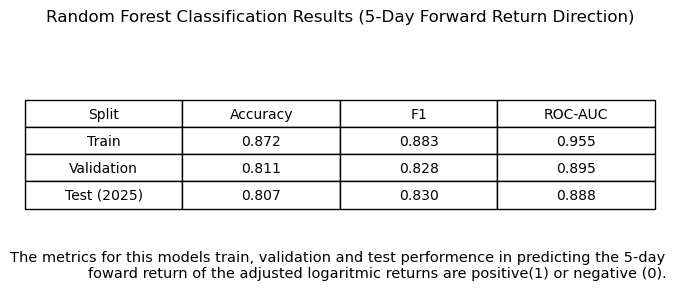

Saved metrics_table.png


<Figure size 640x480 with 0 Axes>

In [193]:
def save_metrics_table(summary_df, outfile="rfcl_metrics_table.png"):
    df = summary_df.copy()
    #  Format numbers
    for col in ["Accuracy", "F1", "ROC-AUC"]:
        if col in df.columns:
            df[col] = df[col].apply(lambda x: "" if pd.isna(x) else f"{x:.3f}")

    fig, ax = plt.subplots(figsize=(6.6, 1.6 + 0.4*len(df)))
    ax.axis("off")
    tbl = ax.table(cellText=df.values, colLabels=df.columns, loc="center", cellLoc="center")
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(10)
    tbl.scale(1, 1.4)
    fig.tight_layout()
    plt.title('Random Forest Classification Results (5-Day Forward Return Direction)')
    plt.savefig(outfile, dpi=200, bbox_inches="tight")
    caption =("""The metrics for this models train, validation and test performence in predicting the 5-day 
                foward return of the adjusted logaritmic returns are positive(1) or negative (0).""")
    plt.figtext(0.5, 0.07, caption, wrap=True, horizontalalignment='center', fontsize=10.5)
    plt.show()
    plt.savefig("rfclass_metrics_table.png", dpi=300, bbox_inches="tight")
    plt.close(fig)
    
# usage
save_metrics_table(summary, "rfcl_metrics_table.png")
print("Saved metrics_table.png")

X_train_classif = X_train   
y_train_classif = y_train





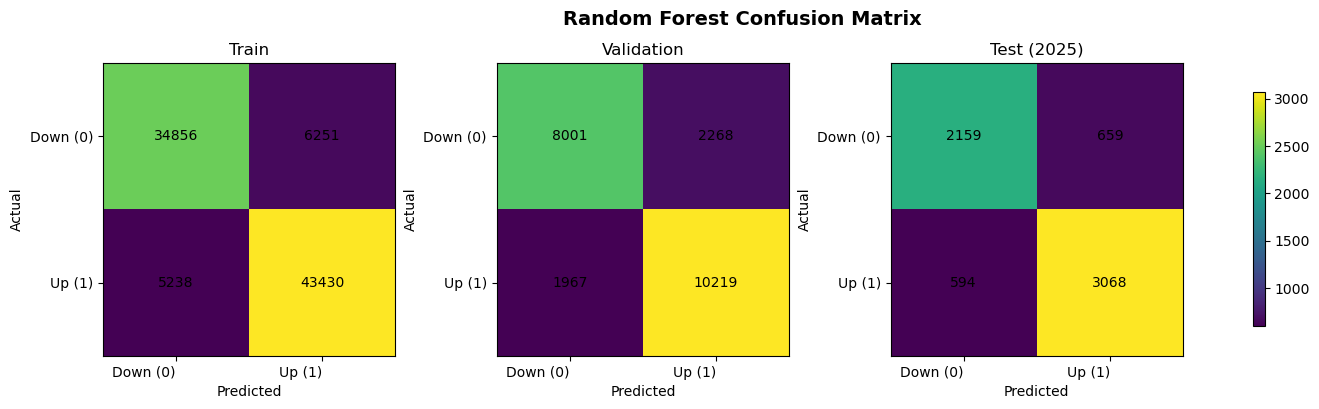

Saved confusion_matrices.png


In [207]:
def save_confusion_matrices(results, labels=("Down (0)", "Up (1)"), outfile="confusion_matrices.png", normalize=False, title="Confusion Matrices"):
    k = len(results)
    fig, axes = plt.subplots(1, k, figsize=(6.0*k, 3.8))

    if k == 1:
        axes = [axes]

    for ax, r in zip(axes, results):
        cm = r["Confusion Matrix"]
        if normalize:
            cm = cm.astype(float)
            row_sums = cm.sum(axis=1, keepdims=True)
            cm = np.divide(cm, np.where(row_sums==0, 1, row_sums))

        im = ax.imshow(cm, interpolation="nearest")
        ax.set_title(r["Split"])
        ax.set_xticks([0,1]); ax.set_xticklabels(labels, ha="right")
        ax.set_yticks([0,1]); ax.set_yticklabels(labels)
        ax.set_xlabel("Predicted"); ax.set_ylabel("Actual")

        # numbers in cells
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                text_val = f"{cm[i,j]:.2f}" if normalize else f"{int(cm[i,j])}"
                ax.text(j, i, text_val, ha="center", va="center")

    fig.suptitle(title, fontsize=14, weight="bold", y=1.02)
    fig.colorbar(im, ax=axes, shrink=0.8)
    # fig.tight_layout()
    plt.savefig(outfile, dpi=200, bbox_inches="tight")
    plt.show()
    plt.close(fig)

# usage
save_confusion_matrices(results, outfile="confusion_matrices.png", normalize=False, title="Random Forest Confusion Matrix")
print("Saved confusion_matrices.png")

In [89]:
# Random Forest Regressor


rfreg_feat = ['y_fwd5', 'Lag1','Lag2','Lag5','Vol20','EMA20','SMA5','SMA20','BollPct', 'Mom5','Mom10', 'RSI14',
                'NASDAQ_lag1','NASDAQ_Vol20','NASDAQ_EMA20',
                'SP500_lag1','SP500_Vol20','SP500_EMA20',
               'Dow_Jones_lag1','Dow_Jones_Vol20','Dow_Jones_EMA20'
               ]


df = all_stocks_sort.sort_values(['Ticker','Date']).reset_index(drop=True)


num_cols_cls = [c for c in rfreg_feat if c != 'y_fwd5']
X = df[['Ticker'] + num_cols_cls].copy()                # KEEP Ticker
y = df['y_fwd5'].copy()

# Split using your per-ticker time mask
X_train, y_train = X.loc[~mask_val], y.loc[~mask_val]
X_val,   y_val   = X.loc[ mask_val], y.loc[ mask_val]

# Drop any rows with NaNs (keep alignment)
keep_tr = X_train.notna().all(axis=1) & y_train.notna()
keep_va = X_val.notna().all(axis=1)   & y_val.notna()
X_train, y_train = X_train[keep_tr], y_train[keep_tr]
X_val,   y_val   = X_val[keep_va],    y_val[keep_va]

pre_reg = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_cols_cls),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), ['Ticker'])
    ],
    remainder='drop'
)

rf = Pipeline([
    ('prep', pre_reg),
    ('rf', RandomForestRegressor(
        n_estimators=1000,
        max_depth=None,
        min_samples_leaf=20,
        max_features='sqrt',
        bootstrap=True,
        random_state=100,
        n_jobs=-1,
        verbose=1
    ))
])

rf.fit(X_train, y_train)

# Evaluate

y_pred = rf.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mae = mean_absolute_error(y_val, y_pred)
r2   = r2_score(y_val, y_pred)



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   34.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  3.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    1.7s finished


In [331]:
print(f"RF (y_fwd5) — RMSE: {rmse:.3f} | MAE: {mae:.3f} | R²: {r2:.3f}")

RF (y_fwd5) — RMSE: 0.024 | MAE: 0.016 | R²: 0.661


In [91]:
# 1) Build X_test / y_test exactly like training/validation  
test_df = all_test_sort.sort_values(['Ticker','Date']).reset_index(drop=True)

# Use the SAME feature list we trained with
num_cols_cls = [c for c in rfreg_feat if c != 'y_fwd5']

# Keep Ticker (needed by the pipeline's OneHotEncoder)
feat_test = test_df[['Ticker'] + num_cols_cls + ['y_fwd5']].copy()

X_test = feat_test[['Ticker'] + num_cols_cls]
y_test = feat_test['y_fwd5']

# 2) Clean NaNs exactly like train/val
keep = X_test[num_cols_cls].notna().all(axis=1) & y_test.notna()
X_test = X_test.loc[keep]
y_test = y_test.loc[keep]

# 3) Predict with same fitted pipeline (clf)
y_pred_test  = rf.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test   = r2_score(y_test, y_pred_test)
print(f"RF (y_fwd5) — RMSE: {rmse_test:.6f} | MAE: {mae_test:.3f}  | R²: {r2_test:.3f}")


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.3s


RF (y_fwd5) — RMSE: 0.030978 | MAE: 0.020  | R²: 0.652


[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.7s finished


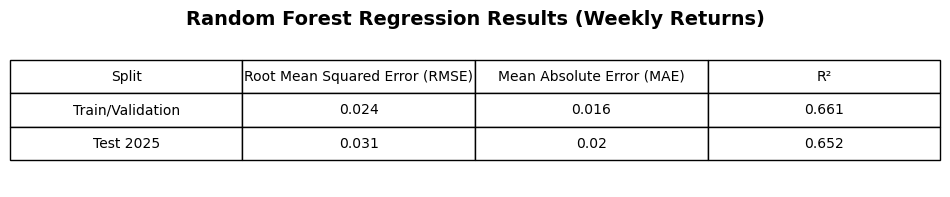

In [93]:
rfreg_summary = {
    "Split": ["Train/Validation", "Test 2025"],
    "Root Mean Squared Error (RMSE)": [rmse, rmse_test],
    "Mean Absolute Error (MAE)": [mae, mae_test],
    "R²": [r2, r2_test]
}

# Convert to DataFrame
df_summary = pd.DataFrame(rfreg_summary)

# Plot as table
fig, ax = plt.subplots(figsize=(6, 2))
ax.axis('off')

table = ax.table(
    cellText=df_summary.round(3).values,   # <-- array of cell values
    colLabels=df_summary.columns.tolist(), # <-- list of column names
    loc='center',
    cellLoc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(2, 2)

plt.title("Random Forest Regression Results (Weekly Returns)", fontsize=14, weight='bold')
plt.savefig("rfreg_metrics_table.png", dpi=300, bbox_inches="tight")
plt.show()





            Feature  Importance
8              Mom5    0.227505
5              SMA5    0.226623
4             EMA20    0.101429
1              Lag2    0.058646
9             Mom10    0.053361
0              Lag1    0.050421
7           BollPct    0.040785
6             SMA20    0.029717
10            RSI14    0.024370
19  Dow_Jones_EMA20    0.022867
16      SP500_EMA20    0.020255
17   Dow_Jones_lag1    0.018264
14       SP500_lag1    0.017612
13     NASDAQ_EMA20    0.016432
11      NASDAQ_lag1    0.015926
3             Vol20    0.014955
2              Lag5    0.014787
12     NASDAQ_Vol20    0.014179
18  Dow_Jones_Vol20    0.014133
15      SP500_Vol20    0.014119


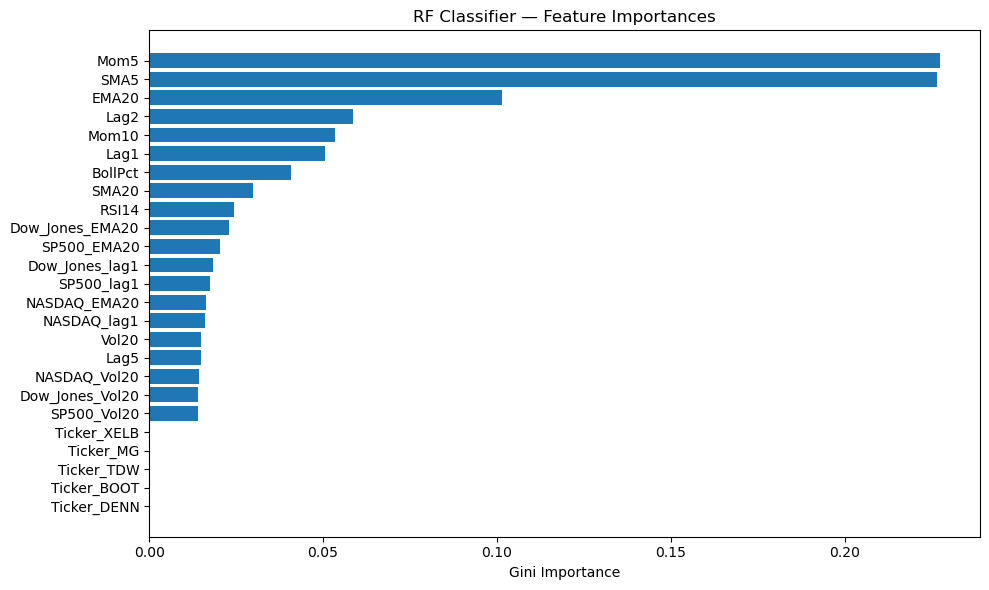

In [213]:
# ---- RandomForest CLASSIFIER feature importances (inside Pipeline) ----
import pandas as pd
import matplotlib.pyplot as plt

# 1) pull fitted RF from pipeline
rf_clf = clf.named_steps['rf']

# 2) rebuild post-preprocessing feature names
num_features = list(num_cols_cls)  # the numeric columns just passed through with no change
cat_features = []
prep = clf.named_steps['prep']
if 'cat' in prep.named_transformers_:
    ohe = prep.named_transformers_['cat']
    cat_features = list(ohe.get_feature_names_out(['Ticker']))

all_features = num_features + cat_features

# 3) match importances -> names
imp = pd.DataFrame(
    {"Feature": all_features, "Importance": rf_clf.feature_importances_}
).sort_values("Importance", ascending=False)

print(imp.head(20))

# 4) plot most important features
topk = 25
plt.figure(figsize=(10,6))
plt.barh(imp["Feature"][:topk][::-1], imp["Importance"][:topk][::-1])
plt.title("RF Classifier — Feature Importances")
plt.xlabel("Gini Importance")
plt.savefig("rclass_import_table.png", dpi=300, bbox_inches="tight")
plt.tight_layout()
plt.show()

            Feature  Importance
8              Mom5    0.240925
5              SMA5    0.238184
4             EMA20    0.126157
9             Mom10    0.067108
0              Lag1    0.056751
1              Lag2    0.053191
6             SMA20    0.032450
7           BollPct    0.025471
19  Dow_Jones_EMA20    0.020149
3             Vol20    0.019665
16      SP500_EMA20    0.016529
10            RSI14    0.014087
17   Dow_Jones_lag1    0.013730
13     NASDAQ_EMA20    0.013381
14       SP500_lag1    0.013235


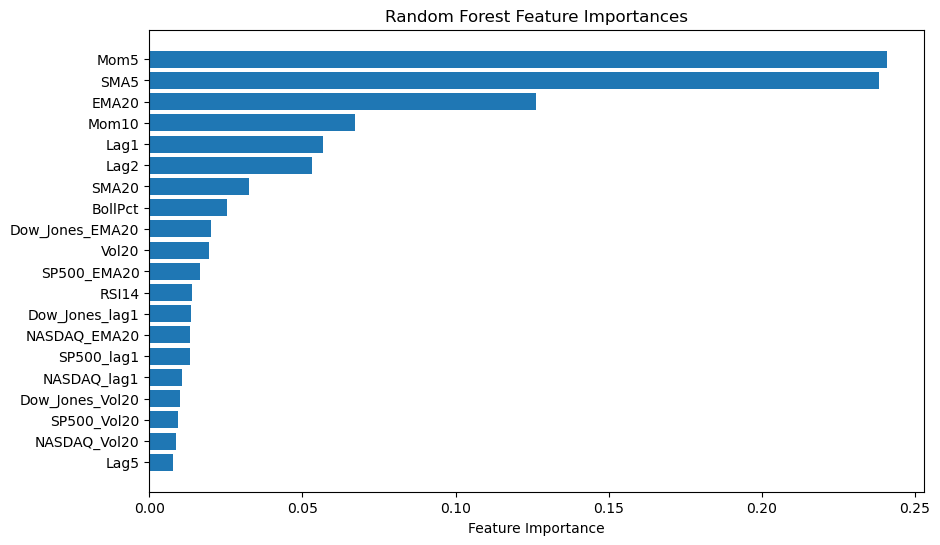

['Ticker_AAPL',
 'Ticker_ABBV',
 'Ticker_AXP',
 'Ticker_BA',
 'Ticker_BOOT',
 'Ticker_CALM',
 'Ticker_CAT',
 'Ticker_CL',
 'Ticker_CSCO',
 'Ticker_CVX',
 'Ticker_DD',
 'Ticker_DENN',
 'Ticker_DIS',
 'Ticker_F',
 'Ticker_GE',
 'Ticker_GM',
 'Ticker_GS',
 'Ticker_HON',
 'Ticker_IBM',
 'Ticker_INTC',
 'Ticker_IP',
 'Ticker_JNJ',
 'Ticker_JPM',
 'Ticker_KO',
 'Ticker_LMT',
 'Ticker_MA',
 'Ticker_MCD',
 'Ticker_MG',
 'Ticker_MMM',
 'Ticker_MS',
 'Ticker_MSFT',
 'Ticker_NKE',
 'Ticker_PEP',
 'Ticker_PFE',
 'Ticker_PG',
 'Ticker_RTX',
 'Ticker_SO',
 'Ticker_T',
 'Ticker_TDW',
 'Ticker_V',
 'Ticker_VZ',
 'Ticker_WFC',
 'Ticker_WMT',
 'Ticker_XELB',
 'Ticker_XOM']

In [329]:


#  1. Get the trained RF model from the pipeline
rf_model = rf.named_steps['rf']

# --- 2. Get feature names after preprocessing
# numeric features (passed through)
num_features = num_cols_cls  

# categorical features (Ticker OHE)
cat_encoder = rf.named_steps['prep'].named_transformers_['cat']
cat_features = list(cat_encoder.get_feature_names_out(['Ticker']))

# full feature list
all_features = num_features + cat_features

#  3. Match importances to names
importances = rf_model.feature_importances_
feat_imp = pd.DataFrame({
    "Feature": all_features,
    "Importance": importances
}).sort_values("Importance", ascending=False)

print(feat_imp.head(15))  # top 15

# --- 4. Plot
plt.figure(figsize=(10,6))
plt.barh(feat_imp["Feature"][:20][::-1], feat_imp["Importance"][:20][::-1])
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importances")
plt.savefig("rfreg_import_table.png", dpi=300, bbox_inches="tight")
plt.show()

cat_features


In [45]:
# !pip3 install lightgbm
from lightgbm import LGBMClassifier

In [97]:
df = all_stocks_sort.sort_values(['Ticker','Date']).reset_index(drop=True)
num_cols_cls = [c for c in no_same_day if c != 'y_up']
X = df[['Ticker'] + num_cols_cls].copy()                # KEEP Ticker
y = df['y_up'].copy()

# 1) per-ticker mask: last 20% as validation (built on THIS df)
test_frac = 0.20
pos = df.groupby('Ticker').cumcount()
n   = df.groupby('Ticker')['Ticker'].transform('size')
cut = (n * (1 - test_frac)).astype(int)
mask_val = pos >= cut               # <-- keep this name consistent

# ---- Split (using existing mask_val)
X_train, y_train = X[~mask_val], y[~mask_val]
X_val,   y_val   = X[ mask_val], y[ mask_val]

# 3) optional: drop rows with any NaNs (RF can’t handle NaN)
keep_tr = X_train.notna().all(axis=1) & y_train.notna()
keep_va = X_val.notna().all(axis=1)   & y_val.notna()
X_train, y_train = X_train[keep_tr], y_train[keep_tr]
X_val,   y_val   = X_val[keep_va],    y_val[keep_va]

# ---- Preprocessor: passthrough numerics, OHE for Ticker
# 1) Preprocessor: passthrough numerics, OHE for Ticker
pre_lg = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_cols_cls),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), ['Ticker'])
    ],
    remainder='drop'
)

# 2) LightGBM classifier (sensible starting params)
lgbm = LGBMClassifier(
    n_estimators=5000,
    learning_rate=0.01,
    num_leaves=63,          # model capacity; try 31–255
    max_depth=-1,           # no hard depth cap; you can try 6–12
    subsample=0.8,          # row sampling
    colsample_bytree=0.8,   # feature sampling
    reg_lambda=1.0,         # L2 regularization
    class_weight=None,      # or 'balanced' if your classes are skewed
    random_state=100,
    n_jobs=-1
)

# 3) Pipeline
lgbm_clf = Pipeline([
    ('prep', pre_cls),
    ('lgbm', lgbm)
])

# 4)
lgbm_clf.fit(X_train, y_train)
### END SOLUTION
#Answer test



[LightGBM] [Info] Number of positive: 48668, number of negative: 41107
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013299 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5190
[LightGBM] [Info] Number of data points in the train set: 89775, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.542111 -> initscore=0.168843
[LightGBM] [Info] Start training from score 0.168843


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['Lag1', 'Lag2', 'Lag5',
                                                   'Vol20', 'EMA20', 'SMA5',
                                                   'SMA20', 'BollPct', 'Mom5',
                                                   'Mom10', 'RSI14',
                                                   'NASDAQ_lag1',
                                                   'NASDAQ_Vol20',
                                                   'NASDAQ_EMA20', 'SP500_lag1',
                                                   'SP500_Vol20', 'SP500_EMA20',
                                                   'Dow_Jones_lag1',
                                                   'Dow_Jones_Vol20',
                                                   'Dow_Jones_EMA20']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Ticker'])])),
                ('lgbm',
                 LGBMClassifier(colsample_bytree=0.8, learning_rate=0.01,
                                n_estimators=5000, n_jobs=-1, num_leaves=63,
                                random_state=100, reg_lambda=1.0,
                                subsample=0.8))])

In [99]:
lgbm_clf.score(X_val,y_val)

# X_train_classif
# y_train_classif

0.8113560454241817

In [102]:
# 5) Evaluate
y_pred = lgbm_clf.predict(X_val)
# y_pred  = (y_proba >= 0.5).astype(int)

print("Accuracy:", accuracy_score(y_val, y_pred))
print("F1 score:", f1_score(y_val, y_pred))
y_prob = lgbm_clf.predict_proba(X_val)[:, 1]
print("ROC-AUC:", roc_auc_score(y_val, y_prob))


Accuracy: 0.8113560454241817
F1 score: 0.8284464603920298
ROC-AUC: 0.8967312527860236


In [103]:
# 1) Build X_test / y_test exactly like training
test_df = all_test_sort.sort_values(['Ticker','Date']).reset_index(drop=True)

# Use the same feature list you trained with
num_cols_cls = [c for c in no_same_day if c != 'y_up']

# Keep Ticker (needed by the pipeline's OneHotEncoder)
feat_test = test_df[['Ticker'] + num_cols_cls + ['y_up']].copy()

X_test = feat_test[['Ticker'] + num_cols_cls]
y_test = feat_test['y_up']

# 2) Clean NaNs exactly like train/val
keep = X_test[num_cols_cls].notna().all(axis=1) & y_test.notna()
X_test = X_test.loc[keep]
y_test = y_test.loc[keep]

# 3) Predict with fitted pipeline (clf)
y_pred_test  = lgbm_clf.predict(X_test)
y_proba_test = lgbm_clf.predict_proba(X_test)[:, 1]


print("Accuracy:", accuracy_score(y_test, y_pred_test))
print("F1 score:", f1_score(y_test, y_pred_test))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_test))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_test))



Accuracy: 0.8092592592592592
F1 score: 0.8336025848142165
Confusion matrix:
 [[2148  670]
 [ 566 3096]]
ROC-AUC: 0.8930449838926554


## Baseline Frequency Counts Model for Classification 

In [161]:
# 1) Find the most frequent class in the training set
p_pos = y_train.mean()               # e.g., 0.62 -> model says "Up" prob = 0.62 for everyone
most_common_class = int(p_pos >= 0.5)

# --- Baseline predictions & probabilities for each split ---
y_pred_baseline_train = np.full_like(y_train, fill_value=most_common_class)
y_proba_baseline_train = np.full(len(y_train), p_pos, dtype=float)

y_pred_baseline       = np.full_like(y_val,   fill_value=most_common_class)
y_proba_baseline      = np.full(len(y_val),   p_pos, dtype=float)

y_pred_baseline_test  = np.full_like(y_test,  fill_value=most_common_class)
y_proba_baseline_test = np.full(len(y_test),  p_pos, dtype=float)


# 3) Evaluate performance
baseline_acc = accuracy_score(y_val, y_pred_baseline)
baseline_f1  = f1_score(y_val, y_pred_baseline, zero_division=0)
baseline_auc = roc_auc_score(y_val, y_proba_baseline)
baseline_cm  = confusion_matrix(y_val, y_pred_baseline)
p_pos = y_train.mean()               # e.g., 0.62 -> model says "Up" prob = 0.62 for everyone
most_common_class = int(p_pos >= 0.5)

print("Baseline (Frequency Count) Classifier")
print(f"Most common class: {most_common_class}")
print(f"Accuracy: {baseline_acc:.3f}")
print(f"F1 Score: {baseline_f1:.3f}")
print(f"ROC-AUC: {baseline_auc:.3f}")
print("Confusion Matrix:\n", baseline_cm)











Baseline (Frequency Count) Classifier
Most common class: 1
Accuracy: 0.543
F1 Score: 0.704
ROC-AUC: 0.500
Confusion Matrix:
 [[    0 10269]
 [    0 12186]]


In [177]:
#Test
#  Baseline on Test ----
y_pred_baseline_test  = np.full_like(y_test, fill_value=most_common_class)

y_proba_baseline_test = np.full(len(y_test), p_pos, dtype=float)  

baseline_acc_test = accuracy_score(y_test, y_pred_baseline_test)
baseline_f1_test  = f1_score(y_test, y_pred_baseline_test, zero_division=0)
baseline_auc_test = roc_auc_score(y_test, y_proba_baseline_test)
baseline_cm_test  = confusion_matrix(y_test, y_pred_baseline_test)

print("\nBaseline (Frequency Count) Classifier - Test Set")
print(f"Accuracy: {baseline_acc_test:.3f}")
print(f"F1 Score: {baseline_f1_test:.3f}")
print(f"ROC-AUC: {baseline_auc_test:.3f}")  
print("Confusion Matrix:\n", baseline_cm_test)




Baseline (Frequency Count) Classifier - Test Set
Accuracy: 0.565
F1 Score: 0.722
ROC-AUC: 0.500
Confusion Matrix:
 [[   0 2818]
 [   0 3662]]


In [183]:
def save_classification_table(y_train, y_val, y_test,
                              y_pred_train, y_pred_val, y_pred_test,
                              model_name, filename,
                              y_proba_train=None, y_proba_val=None, y_proba_test=None):
    """
    Creates and saves a table (Accuracy + F1 + ROC-AUC) for Train/Validation/Test splits.
    ROC-AUC is computed from probabilities if provided; otherwise set to NaN.
    """

    summary = {
        "Split": ["Train", "Validation", "Test (2025)"],
        "Accuracy": [
            accuracy_score(y_train, y_pred_train),
            accuracy_score(y_val,   y_pred_val),
            accuracy_score(y_test,  y_pred_test)
        ],
        "F1 Score": [
            f1_score(y_train, y_pred_train, zero_division=0),
            f1_score(y_val,   y_pred_val,   zero_division=0),
            f1_score(y_test,  y_pred_test,  zero_division=0)
        ],
        "ROC-AUC": [
            roc_auc_score(y_train, y_proba_train) if y_proba_train is not None else np.nan,
            roc_auc_score(y_val,   y_proba_val)   if y_proba_val   is not None else np.nan,
            roc_auc_score(y_test,  y_proba_test)  if y_proba_test  is not None else np.nan,
        ]
    }
    df_summary = pd.DataFrame(summary)

    fig, ax = plt.subplots(figsize=(6, 2))
    ax.axis("off")
    table = ax.table(
        cellText=df_summary.round(3).values,
        colLabels=df_summary.columns,
        loc="center",
        cellLoc="center"
    )
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.2, 1.2)

    plt.title(f"{model_name} Classification (Weekly Return Movements)", fontsize=14, weight="bold")
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()

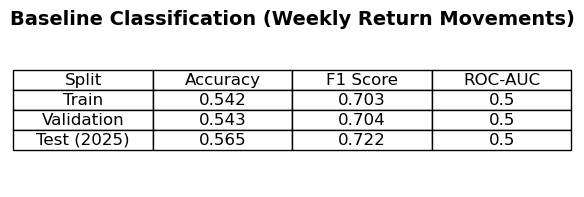

In [185]:
save_classification_table(
    y_train, y_val, y_test,
    y_pred_baseline_train, y_pred_baseline, y_pred_baseline_test,
    'Baseline', "baseline_table.png",
    y_proba_baseline_train, y_proba_baseline, y_proba_baseline_test
)

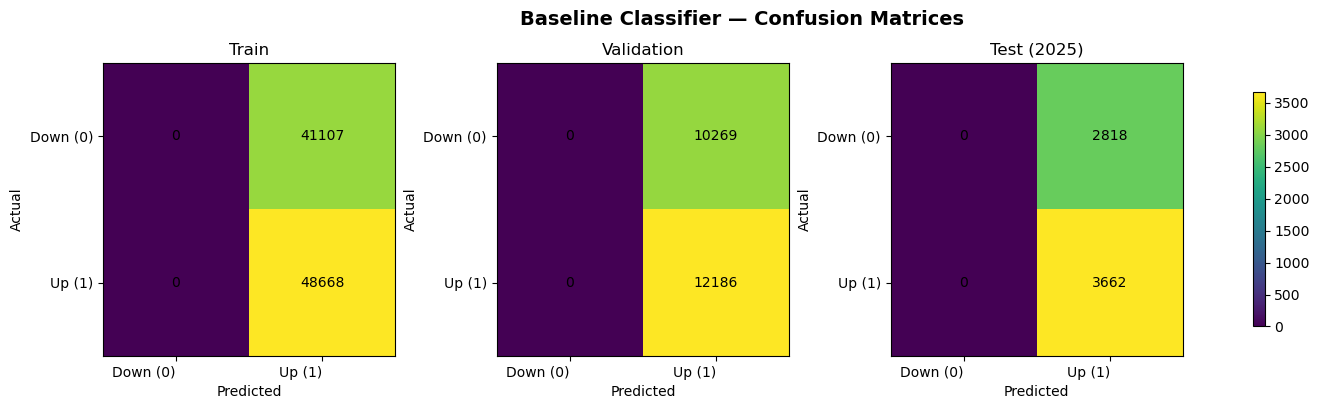

In [211]:
#  Baseline confusion matrices for each split 
cm_train = confusion_matrix(y_train, y_pred_baseline_train)
cm_val   = confusion_matrix(y_val,   y_pred_baseline)
cm_test  = confusion_matrix(y_test,  y_pred_baseline_test)

#  Format  for  plotting functions
baseline_results = [
    {"Split": "Train",       "Confusion Matrix": cm_train},
    {"Split": "Validation",  "Confusion Matrix": cm_val},
    {"Split": "Test (2025)", "Confusion Matrix": cm_test},
]

# Plot & save (counts)
save_confusion_matrices(
    baseline_results,
    labels=("Down (0)", "Up (1)"),
    outfile="baseline_confusion_matrices.png",
    normalize=False,
    title="Baseline Classifier — Confusion Matrices"
)


Transformed shape: (89775, 65)
Feature variances: [4.85244284e-04 4.85405240e-04 4.85265021e-04 1.82009172e-04
 2.22631653e-05 9.13401679e-05 2.23967631e-05 2.41354486e-01
 2.28350420e-03 4.45645348e-03 2.52996655e+01 1.96534179e-04
 5.41181443e-05 7.73898282e-06 1.42463710e-04 4.92113364e-05
 5.53611817e-06 1.41046459e-04 5.20237990e-05 5.72983150e-06]
